In [1]:
# Debug: Examine raw JSON structure to identify data loading issues
import json
from pathlib import Path

# Load one example feature usage file to examine the data
analysis_dir = Path('../outputs/feature_classification/comprehensive_analysis/gemma-2-9b/')
example_files = list(analysis_dir.glob("*_adapter_feature_usage.json"))

if example_files:
    print(f"Examining file: {example_files[0].name}")
    
    with example_files[0].open('r', encoding='utf-8') as f:
        data = json.load(f)
    
    print(f"\n🔍 JSON Structure Analysis:")
    print(f"Top-level keys: {list(data.keys())}")
    
    if 'summary' in data:
        print(f"\nSummary keys: {list(data['summary'].keys())}")
        summary = data['summary']
        print(f"Total usage events: {summary.get('total_usage_events', 'N/A')}")
        print(f"Analysis type: {summary.get('analysis_type', 'N/A')}")
    
    if 'feature_usage_details' in data:
        feature_details = data['feature_usage_details']
        print(f"\nFeature details count: {len(feature_details)}")
        
        if len(feature_details) > 0:
            # Examine the first feature in detail
            first_feature = feature_details[0]
            print(f"\nFirst feature structure:")
            for key, value in first_feature.items():
                print(f"  {key}: {value} (type: {type(value).__name__})")
            
            # Look for related features and examine a few
            related_features = [f for f in feature_details if f.get('classification') == 'related' and f.get('usage_count', 0) > 0]
            print(f"\nFound {len(related_features)} related features with usage > 0")
            
            if len(related_features) >= 3:
                print(f"\nComparing 3 related features:")
                for i, feature in enumerate(related_features[:3]):
                    print(f"\nFeature {i+1}:")
                    usage_count = feature.get('usage_count', 'N/A')
                    usage_pct = feature.get('usage_percentage', 'N/A') 
                    firing_rate = feature.get('firing_rate_percent', 'N/A')
                    total_pos = feature.get('total_positions', 'N/A')
                    
                    print(f"  usage_count: {usage_count}")
                    print(f"  usage_percentage: {usage_pct}")
                    print(f"  firing_rate_percent: {firing_rate}")
                    print(f"  total_positions: {total_pos}")
                    
                    # Manual calculation verification
                    if usage_count != 'N/A' and total_pos != 'N/A' and total_pos > 0:
                        manual_firing_rate = (usage_count / total_pos) * 100
                        print(f"  manual firing rate calc: {manual_firing_rate}")
                    
                    if usage_count != 'N/A' and 'total_usage_events' in summary:
                        total_usage = summary['total_usage_events']
                        manual_usage_pct = (usage_count / total_usage) * 100
                        print(f"  manual usage % calc: {manual_usage_pct}")
            
            # Check if there are any features where firing_rate_percent != usage_percentage ranking
            print(f"\n🔍 Ranking Comparison:")
            related_by_usage = sorted(related_features, key=lambda x: x.get('usage_percentage', 0), reverse=True)
            related_by_firing = sorted(related_features, key=lambda x: x.get('firing_rate_percent', 0), reverse=True)
            
            print(f"Top 5 by usage_percentage:")
            for i, f in enumerate(related_by_usage[:5]):
                print(f"  {i+1}. usage: {f.get('usage_percentage', 0):.6f}, firing: {f.get('firing_rate_percent', 0):.6f}")
            
            print(f"Top 5 by firing_rate_percent:")
            for i, f in enumerate(related_by_firing[:5]):
                print(f"  {i+1}. usage: {f.get('usage_percentage', 0):.6f}, firing: {f.get('firing_rate_percent', 0):.6f}")
            
            # Check if the rankings are identical
            usage_rankings = [f.get('feature_index', i) for i, f in enumerate(related_by_usage)]
            firing_rankings = [f.get('feature_index', i) for i, f in enumerate(related_by_firing)]
            rankings_identical = usage_rankings == firing_rankings
            
            print(f"\nRankings identical? {rankings_identical}")

else:
    print("No adapter feature usage files found!")

Examining file: alignment_steering_analysis_prompt_chosen_ignore_mask_adapter_feature_usage.json

🔍 JSON Structure Analysis:
Top-level keys: ['summary', 'feature_usage_details']

Summary keys: ['analysis_type', 'total_features', 'active_features', 'inactive_features', 'total_usage_events', 'mean_usage_per_active_feature', 'std_usage_per_active_feature', 'top_10_features_usage_percentage', 'classification_breakdown']
Total usage events: 86490115
Analysis type: adapter

Feature details count: 16384

First feature structure:
  feature_index: 15981 (type: int)
  usage_count: 1104143 (type: int)
  usage_percentage: 1.2766117839015476 (type: float)
  classification: not-related (type: str)
  mean_activation: 0.23266984522342682 (type: float)
  std_activation: 1.046013311215083 (type: float)
  firing_rate_percent: 81.81818855464363 (type: float)
  total_positions: 1349508 (type: int)

Found 396 related features with usage > 0

Comparing 3 related features:

Feature 1:
  usage_count: 756161
  

# Steering Analysis Results: Statistical Significance Testing

This notebook analyzes all human-model comparison metrics from the comprehensive steering experiments, calculating p-values and statistical significance for model performance differences.

## Overview:
- **Data Source**: JSON metrics files from `outputs/feature_classification/metrics/`
- **Statistical Tests**: Binomial tests for accuracy, confidence intervals for correlations
- **Output**: Comprehensive table with p-values and significance indicators

In [2]:
# Import Required Libraries
import json
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from scipy.stats import binom, norm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load Steering Analysis Files
analysis_dir = Path('../outputs/feature_classification/comprehensive_analysis/gemma-2-9b/')
print(f"Looking for steering analysis files in: {analysis_dir.absolute()}")

# Find all steering analysis JSON files (exclude feature_usage files and comprehensive summary)
all_steering_files = [f for f in analysis_dir.glob('*steering_analysis*.json') 
                     if '_feature_usage' not in f.name and 'comprehensive_steering_analysis_summary' not in f.name]

print(f"Found {len(all_steering_files)} steering analysis files (including old format):")
for f in sorted(all_steering_files):
    print(f"  - {f.name}")

# Filter out old format files by checking if they have the new structure
steering_files = []
print(f"\nChecking file formats...")

for file in all_steering_files:
    try:
        with file.open('r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Check if file has new structure with sae_adapter and sae_regular
        if 'sae_adapter' in data and 'sae_regular' in data:
            steering_files.append(file)
            print(f"  ✅ {file.name} - New format (has sae_adapter and sae_regular)")
        else:
            print(f"  ⚠️  {file.name} - Old format (missing sae_adapter/sae_regular) - SKIPPING")
    except Exception as e:
        print(f"  ❌ {file.name} - Error reading file: {e} - SKIPPING")

print(f"\n📊 Using {len(steering_files)} files with new format:")
for f in sorted(steering_files):
    print(f"  - {f.name}")

# Find SAE feature usage files
sae_feature_usage_files = [f for f in analysis_dir.glob('*_sae_feature_usage.json')]
print(f"\nFound {len(sae_feature_usage_files)} SAE feature usage files:")
for f in sorted(sae_feature_usage_files):
    print(f"  - {f.name}")

# Find adapter feature usage files  
adapter_feature_usage_files = [f for f in analysis_dir.glob('*_adapter_feature_usage.json')]
print(f"\nFound {len(adapter_feature_usage_files)} adapter feature usage files:")
for f in sorted(adapter_feature_usage_files):
    print(f"  - {f.name}")

if not steering_files:
    print("\n⚠️  No NEW FORMAT steering analysis files found! Make sure to run the updated steering analysis experiments.")
    print("   Run: python src/fsrl/scripts/alignment_steering_analysis.py --run_all_experiments")
else:
    print(f"\n✅ Ready to analyze {len(steering_files)} NEW FORMAT steering experiment results!")
    print(f"✅ Ready to analyze {len(sae_feature_usage_files)} SAE feature usage files!")
    print(f"✅ Ready to analyze {len(adapter_feature_usage_files)} adapter feature usage files!")

Looking for steering analysis files in: /lambda/nfs/fsrl/feature-steering-RL/notebooks/../outputs/feature_classification/comprehensive_analysis/gemma-2-9b
Found 6 steering analysis files (including old format):
  - alignment_steering_analysis_prompt_chosen_ignore_mask.json
  - alignment_steering_analysis_prompt_only_ignore_mask.json
  - alignment_steering_analysis_prompt_rejected_ignore_mask.json
  - formatting_steering_analysis_prompt_chosen_ignore_mask.json
  - formatting_steering_analysis_prompt_only_ignore_mask.json
  - formatting_steering_analysis_prompt_rejected_ignore_mask.json

Checking file formats...
  ✅ alignment_steering_analysis_prompt_chosen_ignore_mask.json - New format (has sae_adapter and sae_regular)
  ✅ alignment_steering_analysis_prompt_only_ignore_mask.json - New format (has sae_adapter and sae_regular)
  ✅ alignment_steering_analysis_prompt_rejected_ignore_mask.json - New format (has sae_adapter and sae_regular)
  ✅ formatting_steering_analysis_prompt_chosen_ignor

In [4]:
# Parse and Structure Steering Analysis Data
all_results = []

def load_feature_usage_data(feature_usage_file):
    """Load and extract key stats from feature usage file."""
    try:
        with feature_usage_file.open('r', encoding='utf-8') as f:
            usage_data = json.load(f)
        
        summary = usage_data.get('summary', {})
        feature_details = usage_data.get('feature_usage_details', [])
        
        # Calculate related feature statistics
        related_features = [f for f in feature_details if f.get('classification') == 'related' and f.get('usage_count', 0) > 0]
        not_related_features = [f for f in feature_details if f.get('classification') == 'not-related' and f.get('usage_count', 0) > 0]
        active_features = [f for f in feature_details if f.get('usage_count', 0) > 0]
        
        total_related_usage = sum(f.get('usage_count', 0) for f in related_features)
        total_not_related_usage = sum(f.get('usage_count', 0) for f in not_related_features)
        total_classified_usage = total_related_usage + total_not_related_usage
        
        related_usage_rate = total_related_usage / total_classified_usage if total_classified_usage > 0 else 0
        
        # Calculate usage-percentage-weighted mean activation values for related features
        # This weights each feature's activation by its usage percentage to account for feature importance
        
        def calculate_weighted_mean_activation(features):
            """Calculate activation weighted by usage percentage (usage_percentage/100 * mean_activation)"""
            if not features:
                return 0
            
            weighted_sum = 0
            total_weight = 0
            
            for f in features:
                mean_activation = f.get('mean_activation', 0)
                usage_percentage = f.get('usage_percentage', 0) / 100.0  # Convert percentage to fraction
                
                if mean_activation is not None and usage_percentage > 0:
                    # Weight the activation by the feature's usage percentage
                    weight = usage_percentage
                    weighted_sum += mean_activation * weight
                    total_weight += weight
            
            return weighted_sum / total_weight if total_weight > 0 else 0
        
        def calculate_weighted_l1_norm(features):
            """Calculate L1 norm of activations weighted by usage percentage"""
            if not features:
                return 0
            
            weighted_sum = 0
            total_weight = 0
            
            for f in features:
                mean_activation = f.get('mean_activation', 0)
                usage_percentage = f.get('usage_percentage', 0) / 100.0  # Convert percentage to fraction
                
                if mean_activation is not None and usage_percentage > 0:
                    # Weight the absolute activation by the feature's usage percentage
                    weight = usage_percentage
                    weighted_sum += abs(mean_activation) * weight
                    total_weight += weight
            
            return weighted_sum / total_weight if total_weight > 0 else 0
        
        # Calculate naive mean for comparison
        related_activations = [f.get('mean_activation', 0) for f in related_features if f.get('mean_activation') is not None]
        not_related_activations = [f.get('mean_activation', 0) for f in not_related_features if f.get('mean_activation') is not None]
        
        mean_related_activation_naive = np.mean(related_activations) if related_activations else 0
        mean_not_related_activation_naive = np.mean(not_related_activations) if not_related_activations else 0
        
        # Calculate usage-percentage-weighted means and L1 norms
        mean_related_activation_weighted = calculate_weighted_mean_activation(related_features)
        mean_not_related_activation_weighted = calculate_weighted_mean_activation(not_related_features)
        
        l1_related_activation_weighted = calculate_weighted_l1_norm(related_features)
        l1_not_related_activation_weighted = calculate_weighted_l1_norm(not_related_features)
        
        return {
            'total_active_features': len(active_features),
            'related_active_features': len(related_features),
            'not_related_active_features': len(not_related_features),
            'related_usage_rate': related_usage_rate,
            'total_usage_events': summary.get('total_usage_events', 0),
            'analysis_type': summary.get('analysis_type', 'unknown'),
            # Weighted means (primary)
            'mean_related_activation': mean_related_activation_weighted,
            'mean_not_related_activation': mean_not_related_activation_weighted,
            # Weighted L1 norms
            'l1_related_activation': l1_related_activation_weighted,
            'l1_not_related_activation': l1_not_related_activation_weighted,
            # Naive means (for comparison)
            'mean_related_activation_naive': mean_related_activation_naive,
            'mean_not_related_activation_naive': mean_not_related_activation_naive
        }
    except Exception as e:
        print(f"Error loading feature usage file {feature_usage_file.name}: {e}")
        return None

for analysis_file in steering_files:
    try:
        with analysis_file.open('r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Check if this file has the new structure (both sae_adapter and sae_regular)
        if 'sae_adapter' not in data or 'sae_regular' not in data:
            print(f"Skipping old format file: {analysis_file.name}")
            continue
        
        # Extract key information from filename
        filename = analysis_file.stem
        # Expected format: "MODE_steering_analysis_RESPONSE_TYPE_ignore_mask"
        # e.g., "alignment_steering_analysis_prompt_chosen_ignore_mask"
        
        parts = filename.split('_')
        if len(parts) >= 3:
            mode = parts[0]  # alignment, formatting
            
            # Extract response type
            if 'prompt_only' in filename:
                response_type = 'prompt_only'
            elif 'prompt_chosen' in filename:
                response_type = 'prompt_chosen'
            elif 'prompt_rejected' in filename:
                response_type = 'prompt_rejected'
            else:
                response_type = 'unknown'
            
            # Check if ignore_mask is used
            ignore_mask = 'ignore_mask' in filename
        else:
            mode = 'unknown'
            response_type = 'unknown'
            ignore_mask = False
        
        # Extract configuration info
        config = data.get('configuration', {})
        
        # Get adapter results (new structure)
        adapter_data = data.get('sae_adapter', {})
        sae_data = data.get('sae_regular', {})
        
        # Verify that both have required fields
        required_fields = ['total_steered_features', 'related_steered', 'steering_related_rate', 'baseline_related_rate']
        if not all(field in adapter_data for field in required_fields) or not all(field in sae_data for field in required_fields):
            print(f"Skipping incomplete data file: {analysis_file.name}")
            continue
        
        # Load corresponding feature usage files
        base_name = filename
        adapter_usage_file = analysis_dir / f"{base_name}_adapter_feature_usage.json"
        sae_usage_file = analysis_dir / f"{base_name}_sae_feature_usage.json"
        
        adapter_usage_stats = load_feature_usage_data(adapter_usage_file) if adapter_usage_file.exists() else None
        sae_usage_stats = load_feature_usage_data(sae_usage_file) if sae_usage_file.exists() else None
        
        # Structure the steering analysis data with both adapter and SAE results
        analysis_record = {
            'filename': filename,
            'mode': mode,
            'response_type': response_type,
            'ignore_mask': ignore_mask,
            'append_response': config.get('append_response'),
            'classification_mode': config.get('classification_mode', mode),
            
            # Adapter results (steering)
            'adapter_total_steered_features': adapter_data.get('total_steered_features', 0),
            'adapter_related_steered': adapter_data.get('related_steered', 0),
            'adapter_not_related_steered': adapter_data.get('not_related_steered', 0),
            'adapter_total_positions_analyzed': adapter_data.get('total_positions_analyzed', 0),
            'adapter_mean_steered_per_position': adapter_data.get('mean_steered_per_position', 0),
            'adapter_baseline_related_rate': adapter_data.get('baseline_related_rate', 0),
            'adapter_steering_related_rate': adapter_data.get('steering_related_rate', 0),
            'adapter_improvement_over_baseline': adapter_data.get('improvement_over_baseline', 0),
            'adapter_l0_norm_mean': adapter_data.get('l0_norm_mean', 0),
            'adapter_l0_norm_std': adapter_data.get('l0_norm_std', 0),
            'adapter_l0_norm_stderr': adapter_data.get('l0_norm_stderr', 0),
            
            # SAE results (baseline)
            'sae_total_active_features': sae_data.get('total_steered_features', 0),
            'sae_related_active': sae_data.get('related_steered', 0),
            'sae_not_related_active': sae_data.get('not_related_steered', 0),
            'sae_total_positions_analyzed': sae_data.get('total_positions_analyzed', 0),
            'sae_mean_active_per_position': sae_data.get('mean_steered_per_position', 0),
            'sae_baseline_related_rate': sae_data.get('baseline_related_rate', 0),
            'sae_related_rate': sae_data.get('steering_related_rate', 0),  # This is the SAE's natural rate
            'sae_improvement_over_theoretical': sae_data.get('improvement_over_baseline', 0),
            'sae_l0_norm_mean': sae_data.get('l0_norm_mean', 0),
            'sae_l0_norm_std': sae_data.get('l0_norm_std', 0),
            'sae_l0_norm_stderr': sae_data.get('l0_norm_stderr', 0),
            
            # Feature usage statistics
            'adapter_usage_stats': adapter_usage_stats,
            'sae_usage_stats': sae_usage_stats,
            
            # Usage-percentage-weighted mean activation values from feature usage data (primary)
            'adapter_mean_related_activation': adapter_usage_stats.get('mean_related_activation', 0) if adapter_usage_stats else 0,
            'sae_mean_related_activation': sae_usage_stats.get('mean_related_activation', 0) if sae_usage_stats else 0,
            'adapter_mean_not_related_activation': adapter_usage_stats.get('mean_not_related_activation', 0) if adapter_usage_stats else 0,
            'sae_mean_not_related_activation': sae_usage_stats.get('mean_not_related_activation', 0) if sae_usage_stats else 0,
            
            # Usage-percentage-weighted L1 norm activation values
            'adapter_l1_related_activation': adapter_usage_stats.get('l1_related_activation', 0) if adapter_usage_stats else 0,
            'sae_l1_related_activation': sae_usage_stats.get('l1_related_activation', 0) if sae_usage_stats else 0,
            'adapter_l1_not_related_activation': adapter_usage_stats.get('l1_not_related_activation', 0) if adapter_usage_stats else 0,
            'sae_l1_not_related_activation': sae_usage_stats.get('l1_not_related_activation', 0) if sae_usage_stats else 0,
            
            # Naive mean activation values (for comparison)
            'adapter_mean_related_activation_naive': adapter_usage_stats.get('mean_related_activation_naive', 0) if adapter_usage_stats else 0,
            'sae_mean_related_activation_naive': sae_usage_stats.get('mean_related_activation_naive', 0) if sae_usage_stats else 0,
            
            # Calculate improvement of adapter over SAE (new baseline)
            'improvement_over_sae': (adapter_data.get('steering_related_rate', 0) - 
                                   sae_data.get('steering_related_rate', 0))
        }
        all_results.append(analysis_record)
        print(f"✅ Loaded new format file: {analysis_file.name}")
        
    except Exception as e:
        print(f"❌ Error processing {analysis_file.name}: {e}")

# Create DataFrame
df = pd.DataFrame(all_results)
print(f"\nLoaded {len(df)} steering analysis results with adapter and SAE data (new format only):")
if len(df) > 0:
    print(f"Modes: {df['mode'].value_counts().to_dict()}")
    print(f"Response types: {df['response_type'].value_counts().to_dict()}")
    print(f"Ignore mask usage: {df['ignore_mask'].value_counts().to_dict()}")
    print(f"Adapter improvement over theoretical baseline: {df['adapter_improvement_over_baseline'].min():.3f} - {df['adapter_improvement_over_baseline'].max():.3f}")
    print(f"SAE improvement over theoretical baseline: {df['sae_improvement_over_theoretical'].min():.3f} - {df['sae_improvement_over_theoretical'].max():.3f}")
    print(f"Adapter improvement over SAE baseline: {df['improvement_over_sae'].min():.3f} - {df['improvement_over_sae'].max():.3f}")
    
    # Show some examples of the new structure including weighted vs naive mean activations
    print(f"\nSample adapter vs SAE rates with usage-percentage-weighted mean activations:")
    for i in range(min(3, len(df))):
        row = df.iloc[i]
        print(f"  {row['mode']}-{row['response_type']}:")
        print(f"    Theoretical baseline: {row['adapter_baseline_related_rate']:.3f}")
        print(f"    SAE rate (new baseline): {row['sae_related_rate']:.3f}")
        print(f"    Adapter rate: {row['adapter_steering_related_rate']:.3f}")
        print(f"    Improvement over SAE: {row['improvement_over_sae']:.3f}")
        print(f"    Adapter {row['mode']} activation (weighted): {row['adapter_mean_related_activation']:.2e}")
        print(f"    Adapter {row['mode']} activation (naive): {row['adapter_mean_related_activation_naive']:.2e}")
        print(f"    Weighting effect: {row['adapter_mean_related_activation'] / row['adapter_mean_related_activation_naive']:.2f}x" if row['adapter_mean_related_activation_naive'] > 0 else "    Weighting effect: N/A")
    
# Display first few rows with key columns including weighted mean activations
print("\nFirst few records (key columns including usage-percentage-weighted mean activations):")
key_columns = ['mode', 'response_type', 'ignore_mask', 'adapter_baseline_related_rate', 
               'sae_related_rate', 'adapter_steering_related_rate', 'improvement_over_sae',
               'adapter_mean_related_activation', 'adapter_mean_related_activation_naive']
display(df[key_columns].head())

✅ Loaded new format file: alignment_steering_analysis_prompt_chosen_ignore_mask.json
✅ Loaded new format file: alignment_steering_analysis_prompt_only_ignore_mask.json
✅ Loaded new format file: alignment_steering_analysis_prompt_rejected_ignore_mask.json
✅ Loaded new format file: formatting_steering_analysis_prompt_chosen_ignore_mask.json
✅ Loaded new format file: formatting_steering_analysis_prompt_only_ignore_mask.json
✅ Loaded new format file: formatting_steering_analysis_prompt_rejected_ignore_mask.json

Loaded 6 steering analysis results with adapter and SAE data (new format only):
Modes: {'alignment': 3, 'formatting': 3}
Response types: {'prompt_chosen': 2, 'prompt_only': 2, 'prompt_rejected': 2}
Ignore mask usage: {True: 6}
Adapter improvement over theoretical baseline: -0.091 - 0.303
SAE improvement over theoretical baseline: 0.001 - 0.023
Adapter improvement over SAE baseline: -0.106 - 0.301

Sample adapter vs SAE rates with usage-percentage-weighted mean activations:
  alignm

,mode,response_type,ignore_mask,adapter_baseline_related_rate,sae_related_rate,adapter_steering_related_rate,improvement_over_sae,adapter_mean_related_activation,adapter_mean_related_activation_naive
0,alignment,prompt_chosen,True,0.178255,0.191204,0.088799,-0.102404,0.065030,0.012427
1,alignment,prompt_only,True,0.178255,0.189381,0.107630,-0.081751,0.154576,0.041749
2,alignment,prompt_rejected,True,0.178255,0.193021,0.087219,-0.105802,0.065046,0.012972
3,formatting,prompt_chosen,True,0.115317,0.117658,0.418484,0.300826,0.046829,0.011132
4,formatting,prompt_only,True,0.115317,0.138655,0.371249,0.232594,0.067797,0.026955


In [5]:
# Calculate Statistical Tests for Steering Analysis (Adapter vs SAE)
def calculate_adapter_vs_sae_significance(adapter_rate, sae_rate, n_positions, confidence=0.95):
    """Calculate confidence interval and p-value for adapter improvement over SAE using binomial test."""
    if n_positions <= 0:
        return None, None, None, None
    
    improvement = adapter_rate - sae_rate
    
    # For confidence intervals, use normal approximation for difference of proportions
    adapter_var = adapter_rate * (1 - adapter_rate) / n_positions
    sae_var = sae_rate * (1 - sae_rate) / n_positions
    se_diff = np.sqrt(adapter_var + sae_var)
    
    alpha = 1 - confidence
    z_crit = norm.ppf(1 - alpha/2)
    ci_lower = improvement - z_crit * se_diff
    ci_upper = improvement + z_crit * se_diff
    
    # Use exact binomial test for p-value
    # Test if adapter rate is significantly different from SAE rate
    adapter_successes = int(round(adapter_rate * n_positions))
    
    # Perform two-tailed binomial test
    # H0: true adapter rate equals SAE rate (null hypothesis: no difference)
    # H1: true adapter rate != SAE rate
    try:
        from scipy.stats import binomtest
        binom_result = binomtest(adapter_successes, n_positions, sae_rate, alternative='two-sided')
        p_value = binom_result.pvalue
    except ImportError:
        # Fallback to older scipy versions
        from scipy.stats import binom_test
        p_value = binom_test(adapter_successes, n_positions, sae_rate, alternative='two-sided')
    
    return improvement, ci_lower, ci_upper, p_value

def steering_significance_level(p_value):
    """Convert p-value to significance symbols."""
    if p_value is None or pd.isna(p_value):
        return ''
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Apply statistical tests comparing adapter vs SAE
df['adapter_vs_sae_ci_lower'] = None
df['adapter_vs_sae_ci_upper'] = None
df['adapter_vs_sae_pvalue'] = None

for idx, row in df.iterrows():
    improvement, ci_lower, ci_upper, p_value = calculate_adapter_vs_sae_significance(
        row['adapter_steering_related_rate'], 
        row['sae_related_rate'], 
        row['adapter_total_positions_analyzed']  # Use adapter positions since that's what we're testing
    )
    df.at[idx, 'adapter_vs_sae_ci_lower'] = ci_lower
    df.at[idx, 'adapter_vs_sae_ci_upper'] = ci_upper
    df.at[idx, 'adapter_vs_sae_pvalue'] = p_value

# Add significance indicators
df['adapter_vs_sae_sig'] = df['adapter_vs_sae_pvalue'].apply(steering_significance_level)
df['positive_vs_sae'] = df['improvement_over_sae'].apply(lambda x: '✓' if x > 0 else '✗')

print("Statistical tests completed (Adapter vs SAE)!")
print(f"Significant improvements over SAE: {(df['adapter_vs_sae_sig'] != '').sum()}/{len(df)}")
print(f"Positive improvements over SAE: {(df['positive_vs_sae'] == '✓').sum()}/{len(df)}")
print(f"Mean improvement over SAE: {df['improvement_over_sae'].mean():.4f}")
print(f"Best improvement over SAE: {df['improvement_over_sae'].max():.4f}")

# Also keep the original theoretical baseline tests for comparison
df['improvement_ci_lower'] = None
df['improvement_ci_upper'] = None
df['improvement_pvalue'] = None

def calculate_improvement_significance(baseline_rate, steering_rate, n_positions, confidence=0.95):
    """Calculate confidence interval and p-value for improvement over theoretical baseline using binomial test."""
    if n_positions <= 0:
        return None, None, None, None
    
    improvement = steering_rate - baseline_rate
    
    # For confidence intervals, still use normal approximation (widely accepted)
    baseline_var = baseline_rate * (1 - baseline_rate) / n_positions
    steering_var = steering_rate * (1 - steering_rate) / n_positions
    se_diff = np.sqrt(baseline_var + steering_var)
    
    alpha = 1 - confidence
    z_crit = norm.ppf(1 - alpha/2)
    ci_lower = improvement - z_crit * se_diff
    ci_upper = improvement + z_crit * se_diff
    
    # Use exact binomial test for p-value
    steering_successes = int(round(steering_rate * n_positions))
    
    try:
        from scipy.stats import binomtest
        binom_result = binomtest(steering_successes, n_positions, baseline_rate, alternative='two-sided')
        p_value = binom_result.pvalue
    except ImportError:
        from scipy.stats import binom_test
        p_value = binom_test(steering_successes, n_positions, baseline_rate, alternative='two-sided')
    
    return improvement, ci_lower, ci_upper, p_value

for idx, row in df.iterrows():
    improvement, ci_lower, ci_upper, p_value = calculate_improvement_significance(
        row['adapter_baseline_related_rate'], 
        row['adapter_steering_related_rate'], 
        row['adapter_total_positions_analyzed']
    )
    df.at[idx, 'improvement_ci_lower'] = ci_lower
    df.at[idx, 'improvement_ci_upper'] = ci_upper
    df.at[idx, 'improvement_pvalue'] = p_value

df['improvement_sig'] = df['improvement_pvalue'].apply(steering_significance_level)
df['positive_improvement'] = df['adapter_improvement_over_baseline'].apply(lambda x: '✓' if x > 0 else '✗')

print(f"\nComparison of statistical tests:")
print(f"Significant vs theoretical baseline: {(df['improvement_sig'] != '').sum()}/{len(df)}")
print(f"Significant vs SAE baseline: {(df['adapter_vs_sae_sig'] != '').sum()}/{len(df)}")
print(f"Mean improvement vs theoretical: {df['adapter_improvement_over_baseline'].mean():.4f}")
print(f"Mean improvement vs SAE: {df['improvement_over_sae'].mean():.4f}")

Statistical tests completed (Adapter vs SAE)!
Significant improvements over SAE: 6/6
Positive improvements over SAE: 3/6
Mean improvement over SAE: 0.0905
Best improvement over SAE: 0.3008

Comparison of statistical tests:
Significant vs theoretical baseline: 6/6
Significant vs SAE baseline: 6/6
Mean improvement vs theoretical: 0.1015
Mean improvement vs SAE: 0.0905


In [6]:
# Create Comprehensive Steering Results Table (Adapter vs SAE Baseline)
def format_number(x, decimals=3):
    """Format number for display."""
    if pd.isna(x) or x is None:
        return 'N/A'
    return f'{x:.{decimals}f}'

def format_ci(lower, upper, decimals=3):
    """Format confidence interval for display."""
    if pd.isna(lower) or pd.isna(upper) or lower is None or upper is None:
        return 'N/A'
    return f'[{lower:.{decimals}f}, {upper:.{decimals}f}]'

def format_percentage(x, decimals=1):
    """Format as percentage."""
    if pd.isna(x) or x is None:
        return 'N/A'
    return f'{x*100:.{decimals}f}%'

def format_activation_scientific(x, decimals=2):
    """Format activation value in scientific notation for display."""
    if pd.isna(x) or x is None:
        return 'N/A'
    return f'{x:.{decimals}e}'

# Prepare display table
results_table = df.copy()
results_table = results_table.sort_values(['mode', 'response_type', 'improvement_over_sae'], ascending=[True, True, False])

# Create formatted columns using SAE as baseline
results_table['SAE Baseline Rate'] = results_table['sae_related_rate'].apply(lambda x: format_percentage(x, 1))
results_table['Adapter Rate'] = results_table['adapter_steering_related_rate'].apply(lambda x: format_percentage(x, 1))
results_table['Improvement over SAE'] = results_table['improvement_over_sae'].apply(lambda x: format_number(x, 4)) + ' ' + results_table['adapter_vs_sae_sig'] + ' ' + results_table['positive_vs_sae']
results_table['Improvement p-value'] = results_table['adapter_vs_sae_pvalue'].apply(lambda x: format_number(x, 4) if x is not None else 'N/A')
results_table['Improvement 95% CI'] = results_table.apply(lambda row: format_ci(row['adapter_vs_sae_ci_lower'], row['adapter_vs_sae_ci_upper'], 4), axis=1)
results_table['Adapter L0 Norm'] = results_table['adapter_l0_norm_mean'].apply(lambda x: format_number(x, 2))
results_table['SAE L0 Norm'] = results_table['sae_l0_norm_mean'].apply(lambda x: format_number(x, 2))
results_table['Adapter Features'] = results_table['adapter_total_steered_features'].astype(int).astype(str)
results_table['SAE Features'] = results_table['sae_total_active_features'].astype(int).astype(str)
results_table['Adapter Related/Total'] = results_table['adapter_related_steered'].astype(str) + '/' + results_table['adapter_total_steered_features'].astype(str)
results_table['SAE Related/Total'] = results_table['sae_related_active'].astype(str) + '/' + results_table['sae_total_active_features'].astype(str)

# Add mean activation and L1 norm columns (adapter only, scientific notation)
results_table['Adapter Mean Activation'] = results_table['adapter_mean_related_activation'].apply(
    lambda x: format_activation_scientific(x, 2)
)
results_table['Adapter L1 Norm'] = results_table['adapter_l1_related_activation'].apply(
    lambda x: format_activation_scientific(x, 2)
)

# Select columns for display
display_columns = [
    'mode', 'response_type', 'ignore_mask', 'SAE Baseline Rate', 'Adapter Rate', 
    'Improvement over SAE', 'Improvement p-value', 'Improvement 95% CI', 
    'Adapter Mean Activation', 'Adapter L1 Norm', 'Adapter L0 Norm', 'SAE L0 Norm', 'Adapter Related/Total', 'SAE Related/Total'
]

final_table = results_table[display_columns].copy()
final_table.columns = ['Mode', 'Response', 'Ignore Mask', 'SAE Baseline %', 'Adapter %', 
                      'Improvement', 'p-value', '95% CI', 'Adapter Activation', 'Adapter L1', 'Adapter L0', 'SAE L0', 
                      'Adapter R/T', 'SAE R/T']

print("🎯 COMPREHENSIVE STEERING ANALYSIS RESULTS (Adapter vs SAE Baseline)")
print("=" * 140)
print("Statistical Significance: *** p<0.001, ** p<0.01, * p<0.05")
print("Improvement Direction: ✓ positive improvement, ✗ negative/no improvement")
print("SAE Baseline %: Rate of related features in regular SAE activations (new baseline)")
print("Adapter %: Rate of related features in adapter steering positions")
print("Improvement: Adapter % - SAE % (with significance and direction)")
print("Adapter Activation: Mean activation values for alignment/style features (scientific notation)")
print("Adapter L1: L1 norm of activation values for alignment/style features (scientific notation)")
print("L0 Norms: Mean number of features active per position")
print("R/T: Related features / Total features used")
print("=" * 140)

# Display with nice formatting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 25)

display(final_table)

# Also show comparison with theoretical baseline for context
print("\n📊 COMPARISON: THEORETICAL vs SAE BASELINE")
print("=" * 80)

comparison_table = df[['mode', 'response_type', 'adapter_baseline_related_rate', 
                      'sae_related_rate', 'adapter_steering_related_rate',
                      'adapter_improvement_over_baseline', 'improvement_over_sae',
                      'improvement_sig', 'adapter_vs_sae_sig']].copy()

comparison_table.columns = ['Mode', 'Response', 'Theoretical', 'SAE', 'Adapter', 
                           'vs Theoretical', 'vs SAE', 'Sig vs Theoretical', 'Sig vs SAE']

# Format percentages
for col in ['Theoretical', 'SAE', 'Adapter']:
    comparison_table[col] = comparison_table[col].apply(lambda x: format_percentage(x, 1))

comparison_table['vs Theoretical'] = comparison_table['vs Theoretical'].apply(lambda x: format_number(x, 4))
comparison_table['vs SAE'] = comparison_table['vs SAE'].apply(lambda x: format_number(x, 4))

print("Shows: Theoretical baseline | SAE baseline | Adapter rate | Improvement vs each baseline")
display(comparison_table)

🎯 COMPREHENSIVE STEERING ANALYSIS RESULTS (Adapter vs SAE Baseline)
Statistical Significance: *** p<0.001, ** p<0.01, * p<0.05
Improvement Direction: ✓ positive improvement, ✗ negative/no improvement
SAE Baseline %: Rate of related features in regular SAE activations (new baseline)
Adapter %: Rate of related features in adapter steering positions
Improvement: Adapter % - SAE % (with significance and direction)
Adapter Activation: Mean activation values for alignment/style features (scientific notation)
Adapter L1: L1 norm of activation values for alignment/style features (scientific notation)
L0 Norms: Mean number of features active per position
R/T: Related features / Total features used


,Mode,Response,Ignore Mask,SAE Baseline %,Adapter %,Improvement,p-value,95% CI,Adapter Activation,Adapter L1,Adapter L0,SAE L0,Adapter R/T,SAE R/T
0,alignment,prompt_chosen,True,19.1%,8.9%,-0.1024 *** ✗,0.0000,"[-0.1032, -0.1016]",6.50e-02,6.63e-02,66.91,179.36,396/2515,2920/16383
1,alignment,prompt_only,True,18.9%,10.8%,-0.0818 *** ✗,0.0000,"[-0.0832, -0.0803]",1.55e-01,1.64e-01,130.03,260.73,339/2219,2920/16383
2,alignment,prompt_rejected,True,19.3%,8.7%,-0.1058 *** ✗,0.0000,"[-0.1066, -0.1050]",6.50e-02,6.63e-02,67.10,177.90,374/2441,2920/16383
3,formatting,prompt_chosen,True,11.8%,41.8%,0.3008 *** ✓,0.0000,"[0.2998, 0.3018]",4.68e-02,5.73e-02,66.91,179.36,457/2515,1889/16383
4,formatting,prompt_only,True,13.9%,37.1%,0.2326 *** ✓,0.0000,"[0.2309, 0.2343]",6.78e-02,1.13e-01,130.03,260.73,416/2219,1889/16383
5,formatting,prompt_rejected,True,11.7%,41.6%,0.2998 *** ✓,0.0000,"[0.2988, 0.3008]",5.08e-02,6.08e-02,67.10,177.90,453/2441,1889/16383



📊 COMPARISON: THEORETICAL vs SAE BASELINE
Shows: Theoretical baseline | SAE baseline | Adapter rate | Improvement vs each baseline


,Mode,Response,Theoretical,SAE,Adapter,vs Theoretical,vs SAE,Sig vs Theoretical,Sig vs SAE
0,alignment,prompt_chosen,17.8%,19.1%,8.9%,-0.0895,-0.1024,***,***
1,alignment,prompt_only,17.8%,18.9%,10.8%,-0.0706,-0.0818,***,***
2,alignment,prompt_rejected,17.8%,19.3%,8.7%,-0.0910,-0.1058,***,***
3,formatting,prompt_chosen,11.5%,11.8%,41.8%,0.3032,0.3008,***,***
4,formatting,prompt_only,11.5%,13.9%,37.1%,0.2559,0.2326,***,***
5,formatting,prompt_rejected,11.5%,11.7%,41.6%,0.3010,0.2998,***,***


📊 COLLECTING INDIVIDUAL FEATURE ACTIVATIONS FROM ALL EXPERIMENTS
  • alignment-prompt_chosen: Found 1640 related features
  • alignment-prompt_only: Found 990 related features
  • alignment-prompt_rejected: Found 1732 related features
  • formatting-prompt_chosen: Found 2885 related features
  • formatting-prompt_only: Found 1924 related features
  • formatting-prompt_rejected: Found 3156 related features

📈 COLLECTED 12327 INDIVIDUAL FEATURE ACTIVATIONS
  • Total features: 12327
  • After outlier removal: 8977 (removed 3350 outliers)
  • Range (original): -1.61e-01 to 6.67e-01
  • Range (filtered): -1.61e-05 to 2.74e-05
  • Outlier bounds: [-1.65e-05, 2.75e-05]
  • Negative values: 3327
  • Zero values: 2
  • Positive values: 5648


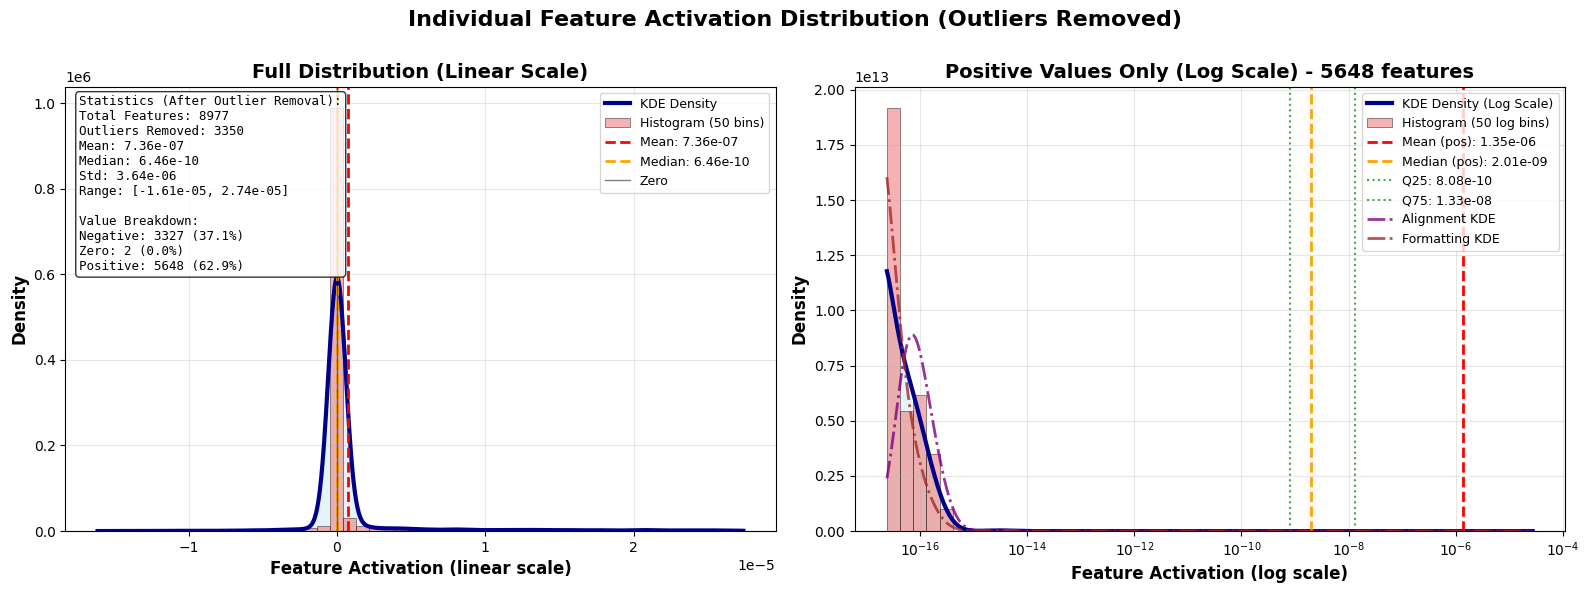


📊 INDIVIDUAL FEATURE ACTIVATION DISTRIBUTION SUMMARY
Distribution of 8977 individual feature activations (after outlier removal):
  • Outliers removed: 3350 (27.2%)
  • Mean: 7.361e-07
  • Median: 6.465e-10
  • Standard Deviation: 3.644e-06
  • Minimum: -1.614e-05
  • Maximum: 2.740e-05
  • Log₁₀ Range (positive only): [-16.62, -4.56]
  • Dynamic Range (positive only): 1131402266514.2x

📋 Value Distribution:
  • Negative values: 3327 (37.1%)
  • Zero values: 2 (0.0%)
  • Positive values: 5648 (62.9%)

📋 Breakdown by Mode (outliers removed):
  • Alignment: 3453 features
    - Mean: 4.512e-07
    - Median: 5.024e-10
    - Range: [-1.442e-05, 2.730e-05]
    - Negative: 1275, Zero: 0, Positive: 2178
  • Formatting: 5524 features
    - Mean: 9.142e-07
    - Median: 6.699e-10
    - Range: [-1.614e-05, 2.740e-05]
    - Negative: 2052, Zero: 2, Positive: 3470

📋 Breakdown by Experiment (outliers removed):
  • alignment-prompt_chosen: 1339 features
  • alignment-prompt_only: 690 features
  • a

In [7]:
# KDE Density Plot: Distribution of Individual Feature Activations from All Experiments
if len(df) > 0:
    # Collect individual feature activations from all experiments
    all_feature_activations = []
    feature_details = []
    
    print("📊 COLLECTING INDIVIDUAL FEATURE ACTIVATIONS FROM ALL EXPERIMENTS")
    print("=" * 70)
    
    # Load individual feature data from the usage files directly
    analysis_dir = Path('../outputs/feature_classification/comprehensive_analysis')
    for _, row in df.iterrows():
        experiment_id = f"{row['mode']}-{row['response_type']}"
        base_name = row['filename']
        adapter_usage_file = analysis_dir / f"{base_name}_adapter_feature_usage.json"
        
        if adapter_usage_file.exists():
            try:
                with adapter_usage_file.open('r', encoding='utf-8') as f:
                    usage_data = json.load(f)
                
                feature_details_list = usage_data.get('feature_usage_details', [])
                related_features = [f for f in feature_details_list 
                                  if f.get('classification') == 'related' 
                                  and f.get('usage_count', 0) > 0
                                  and f.get('mean_activation') is not None]
                
                print(f"  • {experiment_id}: Found {len(related_features)} related features")
                
                # Add individual feature activations (INCLUDING NEGATIVE VALUES)
                for feature in related_features:
                    activation = feature.get('mean_activation', 0)
                    if activation is not None:  # Include all non-None values (positive, negative, zero)
                        all_feature_activations.append(activation)
                        feature_details.append({
                            'experiment': experiment_id,
                            'mode': row['mode'],
                            'activation': activation,
                            'feature_id': feature.get('feature_index', 'unknown'),
                            'usage_count': feature.get('usage_count', 0),
                            'firing_rate': feature.get('firing_rate_percent', 0)
                        })
                        
            except Exception as e:
                print(f"  ❌ Error loading {adapter_usage_file.name}: {e}")
    
    print(f"\n📈 COLLECTED {len(all_feature_activations)} INDIVIDUAL FEATURE ACTIVATIONS")
    
    if len(all_feature_activations) > 0:
        # Convert to numpy array for processing
        all_activations = np.array(all_feature_activations)
        
        # Remove outliers using IQR method
        q1 = np.percentile(all_activations, 25)
        q3 = np.percentile(all_activations, 75)
        iqr = q3 - q1
        
        # Define outliers as values beyond 1.5 * IQR from the quartiles
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Filter out outliers
        outlier_mask = (all_activations >= lower_bound) & (all_activations <= upper_bound)
        filtered_activations = all_activations[outlier_mask]
        n_outliers = len(all_activations) - len(filtered_activations)
        
        print(f"  • Total features: {len(all_activations)}")
        print(f"  • After outlier removal: {len(filtered_activations)} (removed {n_outliers} outliers)")
        print(f"  • Range (original): {all_activations.min():.2e} to {all_activations.max():.2e}")
        print(f"  • Range (filtered): {filtered_activations.min():.2e} to {filtered_activations.max():.2e}")
        print(f"  • Outlier bounds: [{lower_bound:.2e}, {upper_bound:.2e}]")
        
        # Check for negative values
        negative_count = np.sum(filtered_activations < 0)
        positive_count = np.sum(filtered_activations > 0)
        zero_count = np.sum(filtered_activations == 0)
        
        print(f"  • Negative values: {negative_count}")
        print(f"  • Zero values: {zero_count}")
        print(f"  • Positive values: {positive_count}")
        
        if len(filtered_activations) > 1:  # Need at least 2 points for KDE
            # Create figure with two subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
            
            # ============ SUBPLOT 1: Linear Scale (Full Distribution) ============
            from scipy.stats import gaussian_kde
            
            # KDE on original scale (including negative values)
            kde_linear = gaussian_kde(filtered_activations)
            x_linear = np.linspace(filtered_activations.min(), filtered_activations.max(), 1000)
            density_linear = kde_linear(x_linear)
            
            # Plot linear scale
            ax1.plot(x_linear, density_linear, linewidth=3, color='darkblue', label='KDE Density')
            ax1.fill_between(x_linear, density_linear, alpha=0.3, color='lightblue')
            
            # Add histogram
            n_bins_linear = min(50, max(20, len(filtered_activations) // 10))
            ax1.hist(filtered_activations, bins=n_bins_linear, density=True, alpha=0.6, 
                    color='lightcoral', edgecolor='black', linewidth=0.5, 
                    label=f'Histogram ({n_bins_linear} bins)')
            
            # Statistics for linear scale
            mean_val = filtered_activations.mean()
            median_val = np.median(filtered_activations)
            
            ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {mean_val:.2e}')
            ax1.axvline(median_val, color='orange', linestyle='--', linewidth=2, 
                       label=f'Median: {median_val:.2e}')
            ax1.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5,
                       label='Zero')
            
            ax1.set_xlabel('Feature Activation (linear scale)', fontsize=12, fontweight='bold')
            ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
            ax1.set_title('Full Distribution (Linear Scale)', fontsize=14, fontweight='bold')
            ax1.legend(loc='upper right', fontsize=9)
            ax1.grid(True, alpha=0.3)
            
            # ============ SUBPLOT 2: Log Scale (Positive Values Only) ============
            
            # For log scale, we need positive values only
            positive_activations = filtered_activations[filtered_activations > 0]
            
            if len(positive_activations) > 1:
                log_activations = np.log10(positive_activations)
                
                # KDE on log scale
                kde_log = gaussian_kde(log_activations)
                x_log_range = np.linspace(log_activations.min(), log_activations.max(), 1000)
                density_log = kde_log(x_log_range)
                
                # Convert back to original scale for plotting
                x_original_scale = 10**x_log_range
                
                # Adjust density for the scale transformation
                density_adjusted = density_log / (x_original_scale * np.log(10))
                
                # Plot on log scale
                ax2.plot(x_original_scale, density_adjusted, linewidth=3, color='darkblue', 
                        label='KDE Density (Log Scale)')
                ax2.fill_between(x_original_scale, density_adjusted, alpha=0.3, color='lightblue')
                
                # Add histogram on log scale
                n_bins_log = min(50, max(15, len(positive_activations) // 5))
                ax2.hist(positive_activations, bins=np.logspace(np.log10(positive_activations.min()), 
                                                               np.log10(positive_activations.max()), 
                                                               n_bins_log), 
                        density=True, alpha=0.6, color='lightcoral', edgecolor='black', linewidth=0.5,
                        label=f'Histogram ({n_bins_log} log bins)')
                
                ax2.set_xscale('log')
                
                # Statistics on log scale (positive values only)
                pos_mean = positive_activations.mean()
                pos_median = np.median(positive_activations)
                ax2.axvline(pos_mean, color='red', linestyle='--', linewidth=2, 
                           label=f'Mean (pos): {pos_mean:.2e}')
                ax2.axvline(pos_median, color='orange', linestyle='--', linewidth=2, 
                           label=f'Median (pos): {pos_median:.2e}')
                
                # Quartiles for positive values
                q25_pos = np.percentile(positive_activations, 25)
                q75_pos = np.percentile(positive_activations, 75)
                ax2.axvline(q25_pos, color='green', linestyle=':', linewidth=1.5, alpha=0.7,
                           label=f'Q25: {q25_pos:.2e}')
                ax2.axvline(q75_pos, color='green', linestyle=':', linewidth=1.5, alpha=0.7,
                           label=f'Q75: {q75_pos:.2e}')
                
                ax2.set_title(f'Positive Values Only (Log Scale) - {len(positive_activations)} features', 
                             fontsize=14, fontweight='bold')
            else:
                ax2.text(0.5, 0.5, 'Insufficient positive values\nfor log scale plot', 
                        ha='center', va='center', transform=ax2.transAxes, fontsize=12)
                ax2.set_title('Log Scale Plot (Insufficient Data)', fontsize=14, fontweight='bold')
            
            # Color-code by mode if we have mode information
            mode_breakdown = {}
            mode_breakdown_filtered = {}
            for i, detail in enumerate(feature_details):
                if outlier_mask[i]:  # Only include non-outliers
                    mode = detail['mode']
                    if mode not in mode_breakdown_filtered:
                        mode_breakdown_filtered[mode] = []
                    mode_breakdown_filtered[mode].append(detail['activation'])
            
            # Add mode-specific distributions as overlays
            colors = ['purple', 'brown', 'pink', 'gray']
            for i, (mode, activations) in enumerate(mode_breakdown_filtered.items()):
                if len(activations) > 3:  # Need enough points for meaningful KDE
                    mode_activations = np.array(activations)
                    mode_positive = mode_activations[mode_activations > 0]
                    if len(mode_positive) > 3:
                        mode_log = np.log10(mode_positive)
                        mode_kde = gaussian_kde(mode_log)
                        mode_density_log = mode_kde(x_log_range)
                        mode_density_adjusted = mode_density_log / (x_original_scale * np.log(10))
                        ax2.plot(x_original_scale, mode_density_adjusted, linewidth=2, 
                                color=colors[i % len(colors)], alpha=0.8,
                                linestyle='-.', label=f'{mode.title()} KDE')
            
            ax2.set_xlabel('Feature Activation (log scale)', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Density', fontsize=12, fontweight='bold')
            ax2.legend(loc='upper right', fontsize=9, ncol=1)
            ax2.grid(True, alpha=0.3)
            
            # Add text box with summary statistics to the left plot
            stats_text = f"""Statistics (After Outlier Removal):
Total Features: {len(filtered_activations)}
Outliers Removed: {n_outliers}
Mean: {mean_val:.2e}
Median: {median_val:.2e}
Std: {filtered_activations.std():.2e}
Range: [{filtered_activations.min():.2e}, {filtered_activations.max():.2e}]

Value Breakdown:
Negative: {negative_count} ({negative_count/len(filtered_activations)*100:.1f}%)
Zero: {zero_count} ({zero_count/len(filtered_activations)*100:.1f}%)
Positive: {positive_count} ({positive_count/len(filtered_activations)*100:.1f}%)"""
            
            ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    fontsize=9, fontfamily='monospace')
            
            plt.suptitle('Individual Feature Activation Distribution (Outliers Removed)', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Print detailed summary
            print("\n📊 INDIVIDUAL FEATURE ACTIVATION DISTRIBUTION SUMMARY")
            print("=" * 70)
            print(f"Distribution of {len(filtered_activations)} individual feature activations (after outlier removal):")
            print(f"  • Outliers removed: {n_outliers} ({n_outliers/len(all_activations)*100:.1f}%)")
            print(f"  • Mean: {mean_val:.3e}")
            print(f"  • Median: {median_val:.3e}")
            print(f"  • Standard Deviation: {filtered_activations.std():.3e}")
            print(f"  • Minimum: {filtered_activations.min():.3e}")
            print(f"  • Maximum: {filtered_activations.max():.3e}")
            
            if len(positive_activations) > 0:
                print(f"  • Log₁₀ Range (positive only): [{np.log10(positive_activations.min()):.2f}, {np.log10(positive_activations.max()):.2f}]")
                print(f"  • Dynamic Range (positive only): {positive_activations.max()/positive_activations.min():.1f}x")
            
            print(f"\n📋 Value Distribution:")
            print(f"  • Negative values: {negative_count} ({negative_count/len(filtered_activations)*100:.1f}%)")
            print(f"  • Zero values: {zero_count} ({zero_count/len(filtered_activations)*100:.1f}%)")
            print(f"  • Positive values: {positive_count} ({positive_count/len(filtered_activations)*100:.1f}%)")
            
            # Mode breakdown
            print(f"\n📋 Breakdown by Mode (outliers removed):")
            for mode, activations in mode_breakdown_filtered.items():
                mode_array = np.array(activations)
                mode_positive = mode_array[mode_array > 0]
                mode_negative = mode_array[mode_array < 0]
                mode_zero = mode_array[mode_array == 0]
                if len(mode_array) > 0:
                    print(f"  • {mode.title()}: {len(mode_array)} features")
                    print(f"    - Mean: {mode_array.mean():.3e}")
                    print(f"    - Median: {np.median(mode_array):.3e}")
                    print(f"    - Range: [{mode_array.min():.3e}, {mode_array.max():.3e}]")
                    print(f"    - Negative: {len(mode_negative)}, Zero: {len(mode_zero)}, Positive: {len(mode_positive)}")
            
            # Experiment breakdown
            print(f"\n📋 Breakdown by Experiment (outliers removed):")
            experiment_counts = {}
            for i, detail in enumerate(feature_details):
                if outlier_mask[i]:
                    exp = detail['experiment']
                    if exp not in experiment_counts:
                        experiment_counts[exp] = 0
                    experiment_counts[exp] += 1
            
            for exp, count in sorted(experiment_counts.items()):
                print(f"  • {exp}: {count} features")
            
        else:
            plt.figure(figsize=(8, 6))
            plt.text(0.5, 0.5, f'Insufficient data for KDE plot\n(Only {len(filtered_activations)} activations after outlier removal)', 
                     ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)
            plt.title('Individual Feature Activation Distribution', fontsize=14, fontweight='bold')
            plt.show()
            print("⚠️  Insufficient data for meaningful KDE visualization.")
    else:
        print("⚠️  No individual feature activation data available.")
else:
    print("⚠️  No experiment data available for individual feature activation distribution plot.")

In [8]:
# Export Steering Analysis Results (Adapter vs SAE)
if len(df) > 0:
    # Save comprehensive results
    output_dir = Path('../outputs/feature_classification/analysis')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Export detailed results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Full results with all columns
    full_results_file = output_dir / f'steering_analysis_adapter_vs_sae_detailed_{timestamp}.csv'
    df.to_csv(full_results_file, index=False)
    
    # Summary table (adapter vs SAE baseline)
    summary_file = output_dir / f'steering_analysis_adapter_vs_sae_summary_{timestamp}.csv'
    final_table.to_csv(summary_file, index=False)
    
    # JSON summary for programmatic access
    json_summary = {
        'timestamp': timestamp,
        'analysis_type': 'adapter_vs_sae',
        'total_experiments': len(df),
        'modes': df['mode'].value_counts().to_dict(),
        'response_types': df['response_type'].value_counts().to_dict(),
        'ignore_mask_usage': df['ignore_mask'].value_counts().to_dict(),
        'positive_improvements_vs_sae': (df['improvement_over_sae'] > 0).sum(),
        'significant_improvements_vs_sae': (df['adapter_vs_sae_sig'] != '').sum(),
        'positive_improvements_vs_theoretical': (df['adapter_improvement_over_baseline'] > 0).sum(),
        'significant_improvements_vs_theoretical': (df['improvement_sig'] != '').sum(),
        'mean_improvement_vs_sae': float(df['improvement_over_sae'].mean()),
        'mean_improvement_vs_theoretical': float(df['adapter_improvement_over_baseline'].mean()),
        'best_experiment_vs_sae': {
            'improvement': float(df['improvement_over_sae'].max()),
            'mode': df.loc[df['improvement_over_sae'].idxmax(), 'mode'],
            'response_type': df.loc[df['improvement_over_sae'].idxmax(), 'response_type'],
            'ignore_mask': bool(df.loc[df['improvement_over_sae'].idxmax(), 'ignore_mask']),
            'adapter_rate': float(df.loc[df['improvement_over_sae'].idxmax(), 'adapter_steering_related_rate']),
            'sae_rate': float(df.loc[df['improvement_over_sae'].idxmax(), 'sae_related_rate']),
            'theoretical_rate': float(df.loc[df['improvement_over_sae'].idxmax(), 'adapter_baseline_related_rate'])
        },
        'baseline_comparison': {
            'mean_theoretical_baseline': float(df['adapter_baseline_related_rate'].mean()),
            'mean_sae_baseline': float(df['sae_related_rate'].mean()),
            'mean_adapter_rate': float(df['adapter_steering_related_rate'].mean()),
            'sae_vs_theoretical_difference': float(df['sae_related_rate'].mean() - df['adapter_baseline_related_rate'].mean())
        },
        'l0_norm_comparison': {
            'mean_sae_l0': float(df['sae_l0_norm_mean'].mean()),
            'mean_adapter_l0': float(df['adapter_l0_norm_mean'].mean()),
            'l0_difference': float((df['adapter_l0_norm_mean'] - df['sae_l0_norm_mean']).mean()),
            'sae_l0_range': [float(df['sae_l0_norm_mean'].min()), float(df['sae_l0_norm_mean'].max())],
            'adapter_l0_range': [float(df['adapter_l0_norm_mean'].min()), float(df['adapter_l0_norm_mean'].max())]
        },
        'feature_usage_comparison': {
            'mean_sae_features_used': float(df['sae_total_active_features'].mean()),
            'mean_adapter_features_used': float(df['adapter_total_steered_features'].mean()),
            'mean_sae_related_features': float(df['sae_related_active'].mean()),
            'mean_adapter_related_features': float(df['adapter_related_steered'].mean()),
            'feature_usage_difference': float((df['adapter_total_steered_features'] - df['sae_total_active_features']).mean())
        }
    }
    
    json_file = output_dir / f'steering_analysis_adapter_vs_sae_summary_{timestamp}.json'
    with json_file.open('w') as f:
        json.dump(json_summary, f, indent=2, default=str)
    
    print(f"\n💾 STEERING ANALYSIS RESULTS EXPORTED (Adapter vs SAE)")
    print(f"Full results: {full_results_file}")
    print(f"Summary table: {summary_file}")
    print(f"JSON summary: {json_file}")
    
    # Display key findings
    print(f"\n🎯 KEY FINDINGS (Adapter vs SAE Baseline):")
    best_exp = json_summary['best_experiment_vs_sae']
    print(f"Best Performance: {best_exp['improvement']:.4f} improvement over SAE")
    print(f"  • Mode: {best_exp['mode']}")
    print(f"  • Response: {best_exp['response_type']}")
    print(f"  • Ignore mask: {best_exp['ignore_mask']}")
    print(f"  • Adapter rate: {best_exp['adapter_rate']:.3f} ({best_exp['adapter_rate']*100:.1f}%)")
    print(f"  • SAE rate (baseline): {best_exp['sae_rate']:.3f} ({best_exp['sae_rate']*100:.1f}%)")
    print(f"  • Theoretical rate: {best_exp['theoretical_rate']:.3f} ({best_exp['theoretical_rate']*100:.1f}%)")
    
    print(f"\nBaseline Comparison Summary:")
    baseline_comp = json_summary['baseline_comparison']
    print(f"  • Theoretical baseline: {baseline_comp['mean_theoretical_baseline']:.3f} ({baseline_comp['mean_theoretical_baseline']*100:.1f}%)")
    print(f"  • SAE baseline: {baseline_comp['mean_sae_baseline']:.3f} ({baseline_comp['mean_sae_baseline']*100:.1f}%)")
    print(f"  • Adapter performance: {baseline_comp['mean_adapter_rate']:.3f} ({baseline_comp['mean_adapter_rate']*100:.1f}%)")
    print(f"  • SAE vs Theoretical difference: {baseline_comp['sae_vs_theoretical_difference']:.4f}")
    
    print(f"\nOverall Summary (Adapter vs SAE):")
    print(f"  • {json_summary['positive_improvements_vs_sae']}/{json_summary['total_experiments']} experiments show positive improvement over SAE")
    print(f"  • {json_summary['significant_improvements_vs_sae']}/{json_summary['total_experiments']} experiments are statistically significant vs SAE")
    print(f"  • Mean improvement over SAE: {json_summary['mean_improvement_vs_sae']:.4f}")
    
    print(f"\nComparison with Theoretical Baseline:")
    print(f"  • {json_summary['positive_improvements_vs_theoretical']}/{json_summary['total_experiments']} experiments show positive improvement over theoretical")
    print(f"  • {json_summary['significant_improvements_vs_theoretical']}/{json_summary['total_experiments']} experiments are statistically significant vs theoretical")
    print(f"  • Mean improvement over theoretical: {json_summary['mean_improvement_vs_theoretical']:.4f}")
    
    print(f"\nSparsity Analysis:")
    l0_comp = json_summary['l0_norm_comparison']
    print(f"  • Mean SAE L0 norm: {l0_comp['mean_sae_l0']:.2f} features per position")
    print(f"  • Mean Adapter L0 norm: {l0_comp['mean_adapter_l0']:.2f} features per position")
    print(f"  • L0 difference (Adapter - SAE): {l0_comp['l0_difference']:.2f} features per position")
    
    print(f"\nFeature Usage Analysis:")
    feature_comp = json_summary['feature_usage_comparison']
    print(f"  • Mean SAE features used: {feature_comp['mean_sae_features_used']:.1f}")
    print(f"  • Mean Adapter features used: {feature_comp['mean_adapter_features_used']:.1f}")
    print(f"  • Difference in total features used: {feature_comp['feature_usage_difference']:.1f}")
    
else:
    print("\n⚠️  No results to export. Run steering analysis experiments first.")


💾 STEERING ANALYSIS RESULTS EXPORTED (Adapter vs SAE)
Full results: ../outputs/feature_classification/analysis/steering_analysis_adapter_vs_sae_detailed_20251115_191845.csv
Summary table: ../outputs/feature_classification/analysis/steering_analysis_adapter_vs_sae_summary_20251115_191845.csv
JSON summary: ../outputs/feature_classification/analysis/steering_analysis_adapter_vs_sae_summary_20251115_191845.json

🎯 KEY FINDINGS (Adapter vs SAE Baseline):
Best Performance: 0.3008 improvement over SAE
  • Mode: formatting
  • Response: prompt_chosen
  • Ignore mask: True
  • Adapter rate: 0.418 (41.8%)
  • SAE rate (baseline): 0.118 (11.8%)
  • Theoretical rate: 0.115 (11.5%)

Baseline Comparison Summary:
  • Theoretical baseline: 0.147 (14.7%)
  • SAE baseline: 0.158 (15.8%)
  • Adapter performance: 0.248 (24.8%)
  • SAE vs Theoretical difference: 0.0110

Overall Summary (Adapter vs SAE):
  • 3/6 experiments show positive improvement over SAE
  • 6/6 experiments are statistically significan

In [9]:
# Create LaTeX Table for Report (Adapter vs SAE Baseline) - Print Only
if len(df) > 0:
    # Function to format labels nicely
    def format_mode_label(mode):
        """Format mode labels for display."""
        if mode == 'alignment':
            return 'Alignment'
        elif mode == 'formatting':
            return 'Style'
        else:
            return mode.title()
    
    def format_response_label(response_type):
        """Format response type labels for display."""
        if response_type == 'prompt_only':
            return 'Prompt Only'
        elif response_type == 'prompt_chosen':
            return 'Prompt + Chosen'
        elif response_type == 'prompt_rejected':
            return 'Prompt + Rejected'
        else:
            return response_type.replace('_', ' ').title()
    
    def format_activation_latex_scientific(x, decimals=2):
        """Format activation value in scientific notation for LaTeX."""
        if pd.isna(x) or x is None:
            return 'N/A'
        # Convert to scientific notation and format for LaTeX
        scientific_str = f'{x:.{decimals}e}'
        # Split mantissa and exponent
        mantissa, exponent = scientific_str.split('e')
        exponent = int(exponent)  # Remove leading zeros from exponent
        return f'${mantissa} \\times 10^{{{exponent}}}$'
    
    def calculate_sae_se(sae_rate, n_positions):
        """Calculate standard error for SAE baseline rate."""
        if n_positions <= 0:
            return None
        return np.sqrt(sae_rate * (1 - sae_rate) / n_positions)
    
    def calculate_improvement_se_vs_sae(sae_rate, adapter_rate, n_positions):
        """Calculate standard error for improvement over SAE."""
        if n_positions <= 0:
            return None
        sae_var = sae_rate * (1 - sae_rate) / n_positions
        adapter_var = adapter_rate * (1 - adapter_rate) / n_positions
        se_diff = np.sqrt(sae_var + adapter_var)
        return se_diff
    
    # First, let's examine the data to understand the new baseline comparison
    print("🔍 DATA INSPECTION (Adapter vs SAE):")
    print("=" * 70)
    print("Sample sizes and baseline comparison with adapter mean activations:")
    inspection_data = df[['mode', 'response_type', 'adapter_total_positions_analyzed', 
                         'adapter_baseline_related_rate', 'sae_related_rate', 
                         'adapter_steering_related_rate', 'improvement_over_sae',
                         'adapter_mean_related_activation', 'adapter_l1_related_activation']].copy()
    inspection_data['adapter_mean_related_activation'] = inspection_data['adapter_mean_related_activation'].apply(lambda x: f'{x:.2e}')
    inspection_data['adapter_l1_related_activation'] = inspection_data['adapter_l1_related_activation'].apply(lambda x: f'{x:.2e}')
    print(inspection_data.to_string(index=False))
    
    # Debug the statistical calculations for adapter vs SAE
    print(f"\nDetailed Statistical Analysis (Adapter vs SAE using Binomial Test):")
    for _, row in df.iterrows():
        improvement = row['improvement_over_sae']
        n = row['adapter_total_positions_analyzed']
        sae_rate = row['sae_related_rate']
        adapter_rate = row['adapter_steering_related_rate']
        
        # Calculate what was tested
        adapter_successes = int(round(adapter_rate * n))
        expected_successes_sae = sae_rate * n
        
        print(f"\n  {row['mode']}-{row['response_type']}:")
        print(f"    Improvement over SAE: {improvement:.8f}")
        print(f"    Sample size: {n:,}")
        print(f"    SAE baseline rate: {sae_rate:.6f} (expected: {expected_successes_sae:.0f} successes)")
        print(f"    Adapter rate: {adapter_rate:.6f} (observed: {adapter_successes} successes)")
        print(f"    Difference: {adapter_successes - expected_successes_sae:.0f} successes")
        print(f"    Adapter mean {row['mode']} activation: {row['adapter_mean_related_activation']:.2e}")
        print(f"    Adapter L1 {row['mode']} activation: {row['adapter_l1_related_activation']:.2e}")
        
        # Check if p-value column exists
        if 'adapter_vs_sae_pvalue' in df.columns:
            print(f"    P-value (binomial vs SAE): {row['adapter_vs_sae_pvalue']:.2e}")
        else:
            print(f"    P-value: Not calculated yet (run statistical tests cell)")
    
    if 'adapter_vs_sae_pvalue' in df.columns:
        print(f"\nP-values range (vs SAE): {df['adapter_vs_sae_pvalue'].min():.2e} to {df['adapter_vs_sae_pvalue'].max():.2e}")
    print(f"Improvements range (vs SAE): {df['improvement_over_sae'].min():.6f} to {df['improvement_over_sae'].max():.6f}")
    print(f"Adapter mean activation range: {df['adapter_mean_related_activation'].min():.2e} to {df['adapter_mean_related_activation'].max():.2e}")
    print(f"Adapter L1 activation range: {df['adapter_l1_related_activation'].min():.2e} to {df['adapter_l1_related_activation'].max():.2e}")
    
    # Create the LaTeX table with booktabs and multicolumn formatting
    print(f"\n📋 CREATING FANCY LATEX TABLE WITH BOOKTABS (Adapter vs SAE Baseline):")
    print("=" * 100)
    
    print(f"\n📄 LATEX TABLE CODE:")
    print("=" * 100)
    
    # Create a fancy booktabs LaTeX table with multicolumn headers and alternating colors
    latex_lines = []
    
    # Table header with packages
    latex_lines.append("% Required packages: \\usepackage{booktabs}")
    latex_lines.append("\\begin{table}[htbp]")
    latex_lines.append("\\centering")
    latex_lines.append("\\caption{Steering Analysis Results: Adapter performance vs SAE baseline. The SAE baseline shows the natural rate at which the unmodified SAE activates related features for each specific response type. Relative change shows the percentage difference between adapter steering and the SAE natural rate.}")
    latex_lines.append("\\label{tab:steering_vs_sae_results}")
    latex_lines.append("\\begin{tabular}{cccc}")
    latex_lines.append("\\toprule")
    latex_lines.append("Feature Type & Data & SAE Baseline (\\%) & Relative Change (\\%) \\\\")
    latex_lines.append("\\midrule")
    
    # Process data by mode groups
    row_counter = 0  # Keep track of row numbers for alternating colors
    
    for mode in sorted(df['mode'].unique()):
        mode_data = df[df['mode'] == mode].copy()
        mode_data = mode_data.sort_values('response_type')
        
        mode_label = format_mode_label(mode)
        
        # Add response type rows with mode in first column
        for idx, (_, row) in enumerate(mode_data.iterrows()):
            # Calculate SAE baseline and its standard error for THIS specific row
            sae_rate = row['sae_related_rate']  # Use the specific SAE rate for this response type
            n_positions = row['adapter_total_positions_analyzed']
            sae_se = calculate_sae_se(sae_rate, n_positions)
            
            if sae_se is not None:
                sae_baseline_formatted = f"{sae_rate*100:.2f} $\\pm$ {sae_se*100:.2f}"
            else:
                sae_baseline_formatted = f"{sae_rate*100:.2f}"
            
            # Calculate improvement and its standard error
            improvement_se = calculate_improvement_se_vs_sae(
                sae_rate, 
                row['adapter_steering_related_rate'], 
                n_positions
            )
            
            # Calculate relative improvement as a percentage
            relative_improvement = row['improvement_over_sae'] / sae_rate if sae_rate > 0 else 0
            
            if improvement_se is not None and sae_rate > 0:
                relative_improvement_se = improvement_se / sae_rate
                improvement_formatted = f"{relative_improvement*100:.2f} $\\pm$ {relative_improvement_se*100:.2f}"
            else:
                improvement_formatted = f"{relative_improvement*100:.2f}"
            
            response_label = format_response_label(row['response_type'])
            
            # Show mode label only in first row of each group
            mode_display = mode_label if idx == 0 else ""
            
            # Each row gets its own SAE baseline (no empty cells)
            latex_lines.append(f"{mode_display} & {response_label} & {sae_baseline_formatted} & {improvement_formatted} \\\\")
            
            row_counter += 1
        
        # Add midrule between modes (only if not the last mode)
        if mode != sorted(df['mode'].unique())[-1]:
            latex_lines.append("\\midrule")
    
    # Table footer
    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")
    latex_lines.append("\\end{table}")
    
    latex_table = "\n".join(latex_lines)
    
    print(latex_table)
    
    # Also create a comparison table showing theoretical vs SAE baselines
    print(f"\n📄 COMPARISON TABLE (Theoretical vs SAE vs Adapter):")
    print("=" * 100)
    
    comparison_latex_lines = []
    comparison_latex_lines.append("% Comparison table showing all three rates with adapter mean activations and L1 norms")
    comparison_latex_lines.append("\\begin{table}[htbp]")
    comparison_latex_lines.append("\\centering")
    comparison_latex_lines.append("\\caption{Baseline Comparison: Theoretical vs SAE vs Adapter Rates}")
    comparison_latex_lines.append("\\label{tab:baseline_comparison}")
    comparison_latex_lines.append("\\begin{tabular}{cccccc}")
    comparison_latex_lines.append("\\begin{tabular}{ccccc}")
    comparison_latex_lines.append("Feature Type & Data & Theoretical (\\%) & SAE (\\%) & Adapter (\\%) & Best Improvement \\\\")
    comparison_latex_lines.append("Feature Type & Data & Theoretical (\\%) & SAE (\\%) & Adapter (\\%) \\\\")
    
    for mode in sorted(df['mode'].unique()):
        mode_data = df[df['mode'] == mode].copy()
        mode_data = mode_data.sort_values('response_type')
        mode_label = format_mode_label(mode)
        
        for idx, (_, row) in enumerate(mode_data.iterrows()):
            response_label = format_response_label(row['response_type'])
            
            theoretical_rate = f"{row['adapter_baseline_related_rate']*100:.1f}"
            sae_rate = f"{row['sae_related_rate']*100:.1f}"
            adapter_rate = f"{row['adapter_steering_related_rate']*100:.1f}"
            
            # Determine which improvement is better
            # Show mode only in first row of group
            mode_display = mode_label if idx == 0 else ""
            
            comparison_latex_lines.append(f"{mode_display} & {response_label} & {theoretical_rate} & {sae_rate} & {adapter_rate} \\\\")
        
        if mode != sorted(df['mode'].unique())[-1]:
            comparison_latex_lines.append("\\midrule")
    
    comparison_latex_lines.append("\\bottomrule")
    comparison_latex_lines.append("\\end{tabular}")
    comparison_latex_lines.append("\\end{table}")
    
    comparison_latex_table = "\n".join(comparison_latex_lines)
    print(comparison_latex_table)

else:
    print("\n⚠️  No results available for LaTeX table generation.")

# Show the main table
print("\n🎯 FINAL LATEX TABLE:")
print("=" * 50)
if 'latex_table' in locals():
    print(latex_table)
else:
    print("LaTeX table not generated - check if data is available.")

🔍 DATA INSPECTION (Adapter vs SAE):
Sample sizes and baseline comparison with adapter mean activations:
      mode   response_type  adapter_total_positions_analyzed  adapter_baseline_related_rate  sae_related_rate  adapter_steering_related_rate  improvement_over_sae adapter_mean_related_activation adapter_l1_related_activation
 alignment   prompt_chosen                           1348852                       0.178255          0.191204                       0.088799             -0.102404                        6.50e-02                      6.63e-02
 alignment     prompt_only                            454868                       0.178255          0.189381                       0.107630             -0.081751                        1.55e-01                      1.64e-01
 alignment prompt_rejected                           1375236                       0.178255          0.193021                       0.087219             -0.105802                        6.50e-02                      6.63e